In [ ]:
# Colab library to upload files to notebook
from google.colab import files
!pip install -q kaggle
from google.colab import drive
drive.mount('/content/gdrive')
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Download ocular disease recognition dataset
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
# Extract the data
import zipfile
zip_ref = zipfile.ZipFile('ocular-disease-recognition-odir5k.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json
 99% 1.60G/1.62G [00:11<00:00, 164MB/s]
100% 1.62G/1.62G [00:12<00:00, 145MB/s]


In [ ]:
!pip install keras-preprocessing
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 16.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from time import time
import random
from keras.preprocessing import image
import cv2
from keras_preprocessing.image import ImageDataGenerator
import tensorflow.keras.optimizers
import tensorflow_addons as tfa
import keras.backend as K

print(tf.__version__)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2.12.0


In [ ]:
df = pd.read_excel('/content/files/ODIR-5K/ODIR-5K/data.xlsx')

In [ ]:
leftEyeKeywords = df['Left-Diagnostic Keywords'].copy()
rightEyeKeywords = df['Right-Diagnostic Keywords'].copy()
     

leftEyeKeywords = leftEyeKeywords.str.split("，")
rightEyeKeywords = rightEyeKeywords.str.split("，")
     

# Retrieve unique keywords from left and right diagnostic keywords

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

res = pd.DataFrame(mlb.fit_transform(rightEyeKeywords),
                   columns=mlb.classes_,
                   index=rightEyeKeywords.index)

allDiagnosisLeft = res.columns.to_list()
len(allDiagnosisLeft)

res = pd.DataFrame(mlb.fit_transform(leftEyeKeywords),
                   columns=mlb.classes_,
                   index=leftEyeKeywords.index)

allDiagnosisRight = res.columns.to_list()
len(allDiagnosisRight)

allDiagnosis=list(set(allDiagnosisLeft+allDiagnosisRight))
print("total different keys diagnosis :", len(allDiagnosis))

# Create a function to sort all keywords into label keywords
# and list row that contains multiple label

test_df = df.copy()
doubleDiagnosisRow = []

def getKeyDiagnosisSingle(colName):
  keyDiagnosis = []
  global doubleDiagnosisRow
  store = True
  for row in range(len(test_df[colName])):
    store = True
    if test_df[colName][row] == 1:
      for lable in test_df.columns[7:]:
        if lable == colName:
          continue
        if test_df[lable][row] == 1:
          doubleDiagnosisRow.append(row)
          store = False
          break
        
      if store == True:
        for i in rightEyeKeywords[row]:
          keyDiagnosis.append(i)
        for i in leftEyeKeywords[row]:
          keyDiagnosis.append(i)
      

  keyDiagnosis = list(set(keyDiagnosis))
  return keyDiagnosis
     

keyNormal = getKeyDiagnosisSingle(test_df.columns[7])
keyDiabetes = getKeyDiagnosisSingle(test_df.columns[8])
keyGlaucoma = getKeyDiagnosisSingle(test_df.columns[9])
keyCataract = getKeyDiagnosisSingle(test_df.columns[10])
keyAMD = getKeyDiagnosisSingle(test_df.columns[11])
keyHypertension = getKeyDiagnosisSingle(test_df.columns[12])
keyMyopia = getKeyDiagnosisSingle(test_df.columns[13])
keyOtherDisease = getKeyDiagnosisSingle(test_df.columns[14])

labelString = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Abnormalities']
keyAll = [keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease]

for i in range(8):
  print(labelString[i], len(keyAll[i]))

keyNormal

total different keys diagnosis : 105
Normal 3
Diabetes 10
Glaucoma 5
Cataract 3
AMD 3
Hypertension 1
Myopia 6
Abnormalities 57


['low image quality', 'normal fundus', 'lens dust']

In [ ]:
# Create permutations of 2 samples from 7 labels
from itertools import permutations

comb = list(permutations(range(1, 8), 2))
comb
# Intersect each label keyword with normal keyword
print("intersect by normal :\n")
for i in range(1,len(keyAll)):
  keyAll[i] = list(set(keyAll[i])-set(keyAll[0]))

for i in range(8):
  print(labelString[i], len(keyAll[i]))
# Intersect each label with each other except normal keywords
print("\nintersect by others :\n")
for i in range(len(keyAll)-1):
  for j in range(6):
    k = j+6*i
    keyAll[i+1] = list(set(keyAll[i+1])-set(keyAll[comb[k][1]]))

for i in range(8):
  print(labelString[i], len(keyAll[i]))
# Create a function to join unique keywords from all label

def getAllRecognizedKey(mkeyAll):
  mallkeyDiagnosis = []
  for i in range(len(mkeyAll)):
    mkeyAll[i] = list(set(mkeyAll[i]))
    mallkeyDiagnosis = mallkeyDiagnosis+list(set(mkeyAll[i]))
  return mallkeyDiagnosis
     

keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease = keyAll[0], keyAll[1], keyAll[2], keyAll[3], keyAll[4], keyAll[5], keyAll[6], keyAll[7]

allkeyDiagnosis = getAllRecognizedKey(keyAll)
len(allkeyDiagnosis)

intersect by normal :

Normal 3
Diabetes 8
Glaucoma 3
Cataract 1
AMD 2
Hypertension 1
Myopia 4
Abnormalities 54

intersect by others :

Normal 3
Diabetes 7
Glaucoma 3
Cataract 1
AMD 2
Hypertension 1
Myopia 4
Abnormalities 54


75

In [ ]:
# Check the number of row that contains multiple label then sort it

doubleDiagnosisRow = list(set(doubleDiagnosisRow))
print("double label row ",len(doubleDiagnosisRow))
doubleDiagnosisRow.sort()
# Find keyword that has not been included in any of label keywords

notlisted = []
listed = False
for row in doubleDiagnosisRow:
  # print(row)
  for ilist in leftEyeKeywords[row]:
    # print(ilist)
    listed = False
    for j in keyAll:
      if ilist in j:
        listed = True
        break
    if listed == False:
      notlisted.append(ilist)

for row in doubleDiagnosisRow:
  for ilist in rightEyeKeywords[row]:
    listed = False
    for j in keyAll:
      if ilist in j:
        listed = True
        break
    if listed == False:
      notlisted.append(ilist)

notlisted = list(set(notlisted))
# notlisted
print("not listed diagnosis key :",len(notlisted))
# Create a function to separate keyword from multiple label row

def intersectFromMultiLabel(mkeyAll):
  mnotRecognizedList = []
  mallkeyDiagnosis = []
  for i in range(len(mkeyAll)):
    mkeyAll[i] = list(set(mkeyAll[i]))
    mallkeyDiagnosis = mallkeyDiagnosis+list(set(mkeyAll[i])) 
  for row in doubleDiagnosisRow:
    notlistedList = []
    listedList = []
    colIndex = []
    ind = []
    tempList = []
    for ilist in leftEyeKeywords[row]:
      if ilist not in mallkeyDiagnosis:
        tempList.append(ilist)
    for ilist in rightEyeKeywords[row]:
      if ilist not in mallkeyDiagnosis:
        tempList.append(ilist)

    for i in range(7, len(test_df.columns)):
      if test_df[test_df.columns[i]][row] == 1:
        colIndex.append(i-7)
    tempList = list(set(tempList))
    isContainAbnormal = 7 in colIndex
    if len(tempList) > 0:
      ind = colIndex
      for ilist in leftEyeKeywords[row]:
        if ilist not in tempList:
          listedList.append(ilist)
      for ilist in rightEyeKeywords[row]:
        if ilist not in tempList:
          listedList.append(ilist)
      
      for ilist in listedList:
        for i in colIndex:    
          if ilist in keyNormal:
            continue
          if ilist in mkeyAll[i]:
            ind.remove(i)

      if len(ind) == 0 and isContainAbnormal:
        ind.append(7)
      if len(ind) == 1 and len(tempList) == 1:
        mkeyAll[ind[0]] = mkeyAll[ind[0]] + tempList
        mkeyAll[ind[0]] = list(set(mkeyAll[ind[0]]))
      else:
        print("not recognize")
        mnotRecognizedList.append(tempList[0])
        mnotRecognizedList = list(set(mnotRecognizedList))

    mallkeyDiagnosis = []
    for i in mkeyAll:
      mallkeyDiagnosis = mallkeyDiagnosis+list(set(i))
  return mkeyAll, mnotRecognizedList
     

itterate = True
notRecognizedList = []
while itterate :
  temp_allkeyDiagnosis = allkeyDiagnosis.copy()
  keyAll, notRecognizedList = intersectFromMultiLabel(keyAll)
  allkeyDiagnosis = getAllRecognizedKey(keyAll)
  # print(len(temp_allkeyDiagnosis), len(allkeyDiagnosis))
  print(notRecognizedList)
  if len(temp_allkeyDiagnosis) == len(allkeyDiagnosis):
    print(True)
    itterate = False
allkeyDiagnosis = getAllRecognizedKey(keyAll)

keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease = keyAll[0], keyAll[1], keyAll[2], keyAll[3], keyAll[4], keyAll[5], keyAll[6], keyAll[7]

for i in range(8):
  print(labelString[i], len(keyAll[i]))

print("\nall recognized key :",len(allkeyDiagnosis))
print("\nnot recognized key : ", list(set(allDiagnosis)-set(allkeyDiagnosis)))
# Add keyword manually into one label keywords

string = 'suspected cataract'
if string in notRecognizedList and string not in allkeyDiagnosis:
  keyAll[3].append(string)
  notRecognizedList.remove(string)
# Remove keyword that contains "lens dust", "optic disk photographically invisible"
# "low image quality" , "no fundus image" or "image offset"

for label in keyAll[:]:
  for key in label[:]:
    if 'lens dust' in key or 'optic disk photographically invisible' in key or \
    'low image quality' in key or 'image offset' in key or 'no fundus image' in key:
      label.remove(key)

double label row  586
not listed diagnosis key : 30
not recognize
not recognize
not recognize
['image offset', 'punctate inner choroidopathy', 'suspected cataract']
not recognize
not recognize
['image offset', 'suspected cataract']
not recognize
not recognize
['image offset', 'suspected cataract']
True
Normal 3
Diabetes 11
Glaucoma 3
Cataract 1
AMD 3
Hypertension 1
Myopia 5
Abnormalities 76

all recognized key : 103

not recognized key :  ['image offset', 'suspected cataract']


(1, 198, 200, 3)

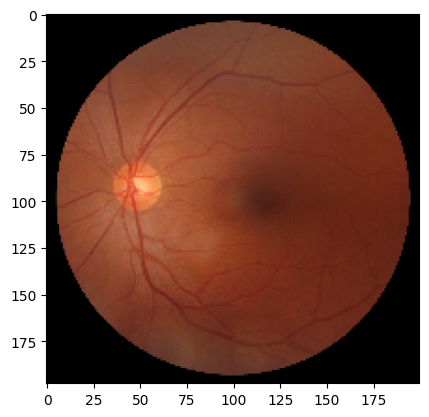

In [ ]:
#define croping function with tensorflow resize
def crop_image(image_path):
  image_data = tf.keras.preprocessing.image.load_img(image_path)
  
  array = tf.keras.preprocessing.image.img_to_array(image_data)
  image = tf.image.resize(
                        array, [200,200], 
                        method='bilinear',
                        preserve_aspect_ratio=True,
                        antialias=False,
                        )
  # image = image / 255.0
  return image
     

#define method for image resize, croping and image Contrast Limited Adaptive Histogram Equalization (CLAHE)
#using Opencv 4

def image_resize(image_path, dim):
  img = cv2.imread(image_path)
  if img.shape[1] != img.shape[0]:
    x = img.shape[1]//2
    y = img.shape[0]//2
    x = x-y
    img = img[0:0+img.shape[0], x:x+img.shape[0]]
  # resize image
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

def CLAHE(image_path, dim, clipLimit, tileGridSize):
  img = image_resize(image_path, dim)
  clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
  l, a, b = cv2.split(lab)  # split on 3 different channels
  l2 = clahe.apply(l)  # apply CLAHE to the L-channel
  lab = cv2.merge((l2,a,b))  # merge channels
  img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img
     

#before CLAHE processing
source = '/content/files/ODIR-5K/ODIR-5K/Training Images/112_left.jpg'
test = crop_image(source)
test = np.array(test)
img = tf.keras.preprocessing.image.array_to_img(test)
plt.imshow(img)
test = np.expand_dims(test, axis=0)
test.shape

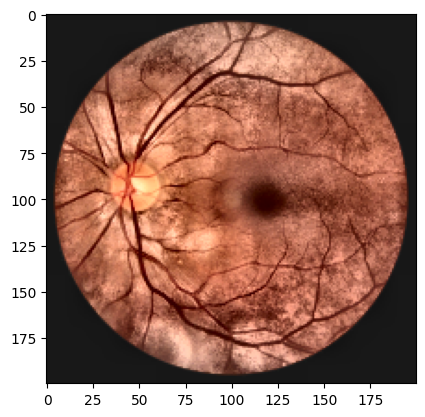

In [ ]:

#showing CLAHE image Preprocessing
source = '/content/files/ODIR-5K/ODIR-5K/Training Images/112_left.jpg'
test = CLAHE(source, (200,200), 20, (10,10))
test = np.array(test)
img = tf.keras.preprocessing.image.array_to_img(test)
plt.imshow(img)
test = test.reshape(1, 200, 200, 3)
test.shape


#set target size image

target_size = (230, 230)
# color_mode = 'grayscale'
color_mode = 'rgb'
if color_mode == 'grayscale':
  shapeadd = (1,)
if color_mode == 'rgb':
  shapeadd = (3,)

In [ ]:
# Create a dataframe containing image filename, keywords and its label

filename = df['Left-Fundus'].values.tolist() + df['Right-Fundus'].values.tolist()
keywords = leftEyeKeywords.values.tolist() + rightEyeKeywords.values.tolist()

# Assign label for each image filename
keywords = leftEyeKeywords.values.tolist() + rightEyeKeywords.values.tolist()

labels = []
for keyword in keywords:
  temp = []
  for key in keyword:
    if key in keyNormal:
      temp.append('N')
      continue
    elif key in keyDiabetes:
      temp.append('D')
      continue
    elif key in keyGlaucoma:
      temp.append('G')
      continue
    elif key in keyCataract:
      temp.append('C')
      continue
    elif key in keyAMD:
      temp.append('A')
      continue
    elif key in keyHypertension:
      temp.append('H')
      continue
    elif key in keyMyopia:
      temp.append('M')
      continue
    elif key in keyOtherDisease:
      temp.append('O')
      continue
  labels.append(temp)

new_df = pd.DataFrame(list(zip(filename, keywords, labels)), columns =['filename', 'keywords', 'label'])
     

# Remove row that contains keyword such as "lens dust", "optic disk photographically invisible"
# "low image quality" or "image offset"

index = []
for idx, row in new_df.iterrows():
  for key in row['keywords']:
    if 'lens dust' in key or 'optic disk photographically invisible' in key or \
    'low image quality' in key or 'image offset' in key:
      index.append(idx)

print(len(index))
new_df = new_df.drop(index)
new_df = new_df.reset_index(drop=True)

new_df

435


,filename,keywords,label
0,0_left.jpg,[cataract],[C]
1,1_left.jpg,[normal fundus],[N]
2,2_left.jpg,"[laser spot, moderate non proliferative retino...","[O, D]"
3,3_left.jpg,[normal fundus],[N]
4,4_left.jpg,[macular epiretinal membrane],[O]
...,...,...,...
6563,4686_right.jpg,[proliferative diabetic retinopathy],[D]
6564,4688_right.jpg,[moderate non proliferative retinopathy],[D]
6565,4689_right.jpg,[normal fundus],[N]
6566,4690_right.jpg,[mild nonproliferative retinopathy],[D]


In [ ]:
# Delete image that is not in the dataframe
unlisted = []

for image in os.listdir('/content/files/ODIR-5K/ODIR-5K/Training Images'):
  if image in new_df['filename'].values.tolist():
    continue
  else:
    unlisted.append(image)

print(unlisted)

for image in unlisted:
  os.remove('/content/files/ODIR-5K/ODIR-5K/Training Images/' + image)

['65_left.jpg', '1096_right.jpg', '1062_left.jpg', '2536_left.jpg', '1970_left.jpg', '577_left.jpg', '2580_right.jpg', '664_left.jpg', '895_right.jpg', '1999_left.jpg', '1657_left.jpg', '3154_left.jpg', '3181_left.jpg', '2598_right.jpg', '2208_left.jpg', '2752_right.jpg', '3239_left.jpg', '2947_right.jpg', '395_right.jpg', '2566_left.jpg', '2875_left.jpg', '875_left.jpg', '3402_left.jpg', '1475_left.jpg', '465_left.jpg', '505_right.jpg', '1134_right.jpg', '2648_left.jpg', '819_right.jpg', '1999_right.jpg', '3055_right.jpg', '2536_right.jpg', '3320_left.jpg', '2251_right.jpg', '2891_left.jpg', '2930_left.jpg', '2674_left.jpg', '222_right.jpg', '3181_right.jpg', '2496_left.jpg', '3300_left.jpg', '2922_right.jpg', '2739_left.jpg', '586_right.jpg', '2727_right.jpg', '2478_right.jpg', '3398_right.jpg', '2620_right.jpg', '1140_right.jpg', '3046_right.jpg', '505_left.jpg', '1463_right.jpg', '989_left.jpg', '70_right.jpg', '2428_right.jpg', '539_right.jpg', '2453_right.jpg', '1974_left.jpg', '

In [ ]:
# Fit the multi-label binarizer on the training set
print("Labels:")
bin_label = list(new_df['label'])
mlb.fit(bin_label)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))
# transform the targets of the training and test sets
bin_label = mlb.transform(bin_label)
     

# Create a list containing path to locate images

filenames = [os.path.join('/content/files/ODIR-5K/ODIR-5K/Training Images', str(f)) for f in new_df['filename']]
filenames[:3]

Labels:
0. A
1. C
2. D
3. G
4. H
5. M
6. N
7. O


['/content/files/ODIR-5K/ODIR-5K/Training Images/0_left.jpg',
 '/content/files/ODIR-5K/ODIR-5K/Training Images/1_left.jpg',
 '/content/files/ODIR-5K/ODIR-5K/Training Images/2_left.jpg']

In [ ]:
# Create a list containing CLAHE images
images = []
for name in filenames:
  images.append(CLAHE(name, target_size, 20, (10,10)))

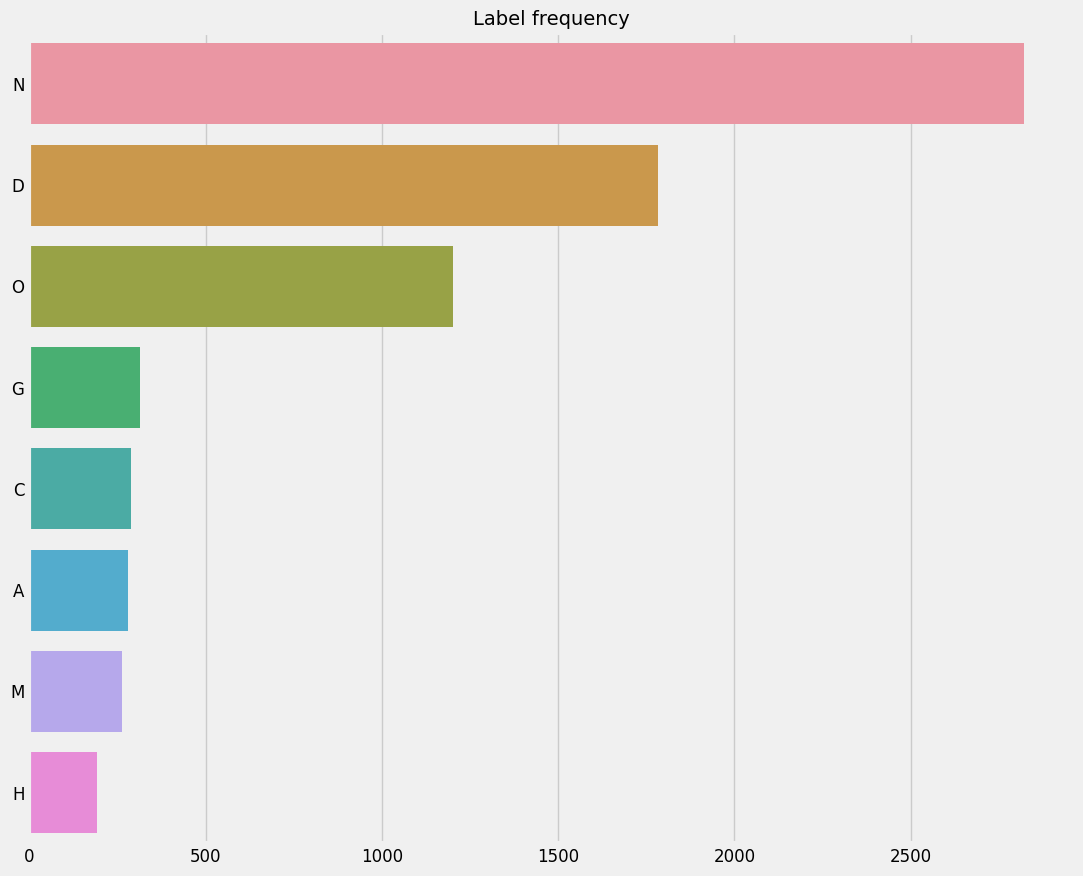

In [ ]:
# Get label frequencies in descending order
label_freq = new_df['label'].explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# stack images into a numpy array
images = np.stack(images, axis=0)
# split data into training, validation, and test sets
training_features, temp_validation_features, training_labels, temp_validation_labels, training_filenames, temp_validation_filenames, training_key, temp_validation_key = train_test_split(images, bin_label, filenames, new_df['label'].values.tolist(), test_size=0.20, random_state=1)
validation_features, test_features, validation_labels, test_labels, validation_filenames, test_filenames, validation_key, test_key = train_test_split(temp_validation_features, temp_validation_labels, temp_validation_filenames, temp_validation_key, test_size=0.50, random_state=1)

print("n training :", len(training_filenames))
print("n validation :", len(validation_filenames))
print("n test :", len(test_filenames))

#delete temporary list file for minimalizing memory usage
del images
del bin_label
del temp_validation_features
del temp_validation_labels
del temp_validation_filenames

n training : 5898
n validation : 536
n test : 134


Training images: 



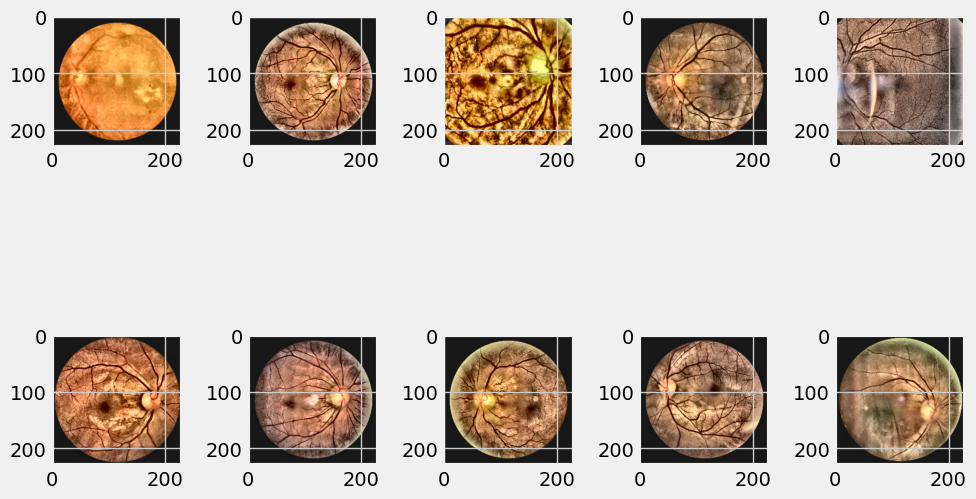

In [ ]:
print('Training images: \n')
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        if color_mode == 'rgb':
          ax[i,j].imshow(training_features[k].reshape(target_size[0], target_size[1], 3) , cmap = "hsv")
        else :
          ax[i,j].imshow(training_features[k].reshape(target_size[0], target_size[1]) , cmap = "gray")
        k += 1
    plt.tight_layout()

Testing images: 



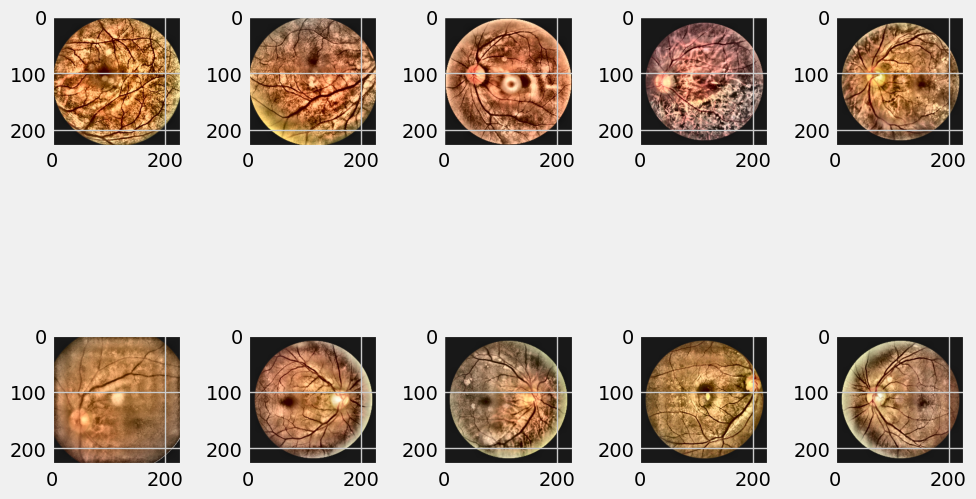

In [ ]:
print('Testing images: \n')
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(validation_features[k].reshape(target_size[0], target_size[1], 3) , cmap = "hsv")
        k += 1
    plt.tight_layout()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   horizontal_flip=True,
                                   #fill_mode='nearest'
                                   )

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(training_features, 
                                     y=training_labels, 
                                     batch_size=32,
                                     )

validation_generator = validation_datagen.flow(validation_features, 
                                               y=validation_labels, 
                                               batch_size=32
                                               )

Build a CNN model with custom layer

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
# Set callback
checkpoint_path = "/content/gdrive/My Drive/Colab Notebooks/Trained_Models/ODIR5K.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1)

stopAccuracy = 0.90

# Define a Callback class that stops training once accuracy reaches the certain accuracy
class callbackStop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy_multilabel')>stopAccuracy):
      print("\nReached", stopAccuracy*100, " accuracy so cancelling training!")
      self.model.stop_training = True

callbackstop = callbackStop()

In [ ]:
AUC_value = tf.keras.metrics.AUC(
                                  # name='AUC values',
                                  # num_thresholds=200, 
                                  curve='ROC', 
                                  summation_method='interpolation',
                                  # thresholds=0.5, 
                                  multi_label=True,
                                  )

F1_score = tfa.metrics.F1Score(
                                num_classes=8,
                                name='F-1 score',
                                average='macro',
                                threshold=0.5,
                              )

In [ ]:
@tf.function
def accuracy_multilabel(y, y_hat):
  correct_prediction = tf.equal(tf.round(y_hat), y)
  # correct_prediction = tf.equal(tf.round(tf.nn.sigmoid(y_hat)), tf.round(y))
  ##mean
  correct_prediction = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  ##all
  # all_labels_true = tf.reduce_min(tf.cast(correct_prediction, tf.float32), 1)
  # correct_prediction = tf.reduce_mean(all_labels_true)
  return correct_prediction

class MetricsAtTopK:
    def __init__(self, k):
        self.k = k

    def _get_prediction_tensor(self, y_pred):
        """Takes y_pred and creates a tensor of same shape with 1 in indices where, the values are in top_k
        """
        topk_values, topk_indices = tf.nn.top_k(y_pred, k=self.k, sorted=False, name="topk")
        # the topk_indices are along last axis (1). Add indices for axis=0
        ii, _ = tf.meshgrid(tf.range(tf.shape(y_pred)[0]), tf.range(self.k), indexing='ij')
        index_tensor = tf.reshape(tf.stack([ii, topk_indices], axis=-1), shape=(-1, 2))
        prediction_tensor = y_pred
        # prediction_tensor =  tf.sparse.to_dense(sparse_indices=index_tensor,
        #                                        output_shape=tf.shape(y_pred),
        #                                        default_value=0,
        #                                        sparse_values=1.0,
        #                                        validate_indices=False
        #                                        )
        prediction_tensor = tf.cast(prediction_tensor, K.floatx())
        return prediction_tensor

    def true_positives_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        return true_positive

    def false_positives_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c2 = K.sum(prediction_tensor)  # TP + FP
        false_positive = c2 - true_positive
        return false_positive

    def false_negatives_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c3 = K.sum(y_true)  # TP + FN
        false_negative = c3 - true_positive
        return false_negative

    def precision_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c2 = K.sum(prediction_tensor)  # TP + FP
        return true_positive/(c2+K.epsilon())

    def recall_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c3 = K.sum(y_true)  # TP + FN
        return true_positive/(c3+K.epsilon())

    def f1_at_k(self, y_true, y_pred):
        precision = self.precision_at_k(y_true=y_true, y_pred=y_pred)
        recall = self.recall_at_k(y_true=y_true, y_pred=y_pred)
        f1 = (2*precision*recall)/(precision+recall+K.epsilon())
        return f1

metricsAtTopK = MetricsAtTopK(k=5)

In [ ]:
epochs = 50
learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer, 
              metrics=[accuracy_multilabel,
                       metricsAtTopK.f1_at_k,
                       AUC_value]
              )
     

history = model.fit(train_generator,
                    validation_data=validation_generator, 
                    epochs=50,
                    verbose=1,
                    callbacks=[callbackstop]
                    )

Epoch 1/50
185/185 [==============================] - 90s 405ms/step - loss: 0.3704 - accuracy_multilabel: 0.8542 - f1_at_k: 0.2636 - auc: 0.5061 - val_loss: 0.3221 - val_accuracy_multilabel: 0.8678 - val_f1_at_k: 0.2752 - val_auc: 0.5507
Epoch 2/50
185/185 [==============================] - 76s 409ms/step - loss: 0.3244 - accuracy_multilabel: 0.8654 - f1_at_k: 0.2767 - auc: 0.5411 - val_loss: 0.3205 - val_accuracy_multilabel: 0.8678 - val_f1_at_k: 0.2798 - val_auc: 0.5787
Epoch 3/50
185/185 [==============================] - 74s 401ms/step - loss: 0.3221 - accuracy_multilabel: 0.8659 - f1_at_k: 0.2782 - auc: 0.5718 - val_loss: 0.3192 - val_accuracy_multilabel: 0.8675 - val_f1_at_k: 0.2865 - val_auc: 0.6121
Epoch 4/50
185/185 [==============================] - 74s 401ms/step - loss: 0.3191 - accuracy_multilabel: 0.8655 - f1_at_k: 0.2814 - auc: 0.5974 - val_loss: 0.3143 - val_accuracy_multilabel: 0.8725 - val_f1_at_k: 0.2975 - val_auc: 0.6305
Epoch 5/50
185/185 [========================

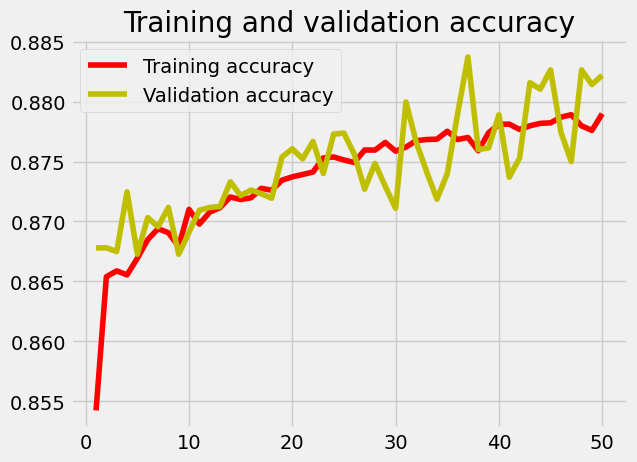

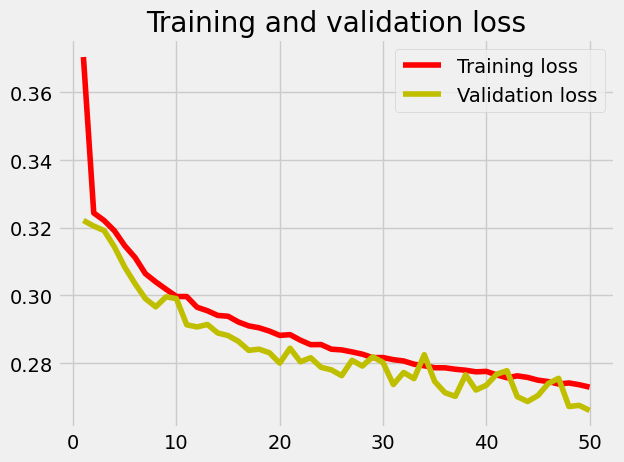

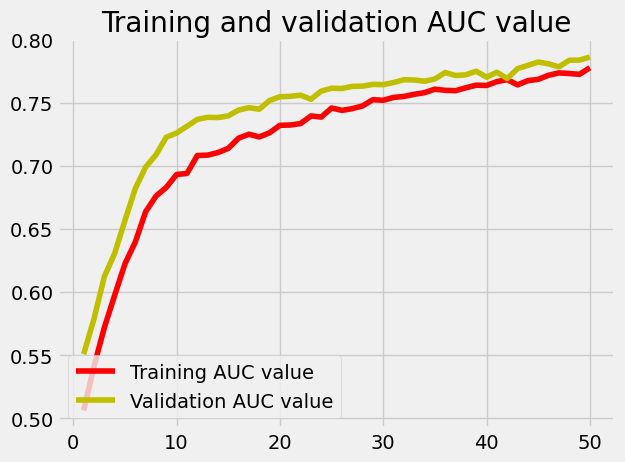

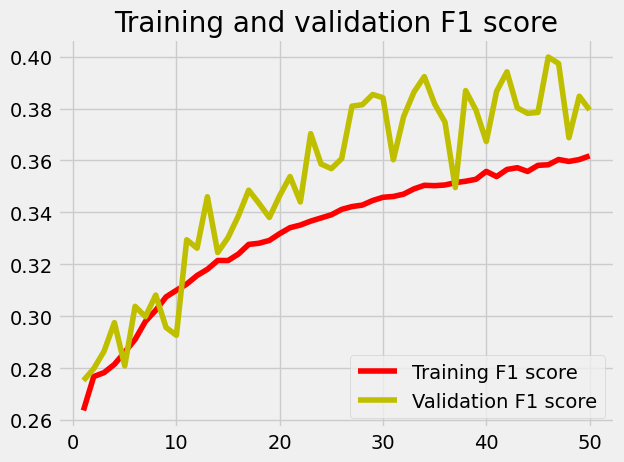

<Figure size 640x480 with 0 Axes>

In [ ]:
f1_str = 'f1_at_k'
val_f1_str = 'val_'+f1_str

acc = history.history['accuracy_multilabel']
val_acc = history.history['val_accuracy_multilabel']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1 = history.history[f1_str]
val_f1 = history.history[val_f1_str]

auc = history.history['auc']
val_auc = history.history['val_auc']

epochs_training = range(1, len(acc)+1)

plt.plot(epochs_training, acc, 'r', label='Training accuracy')
plt.plot(epochs_training, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs_training, loss, 'r', label='Training loss')
plt.plot(epochs_training, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)
plt.figure()

plt.plot(epochs_training, auc, 'r', label='Training AUC value')
plt.plot(epochs_training, val_auc, 'y', label='Validation AUC value')
plt.title('Training and validation AUC value')
plt.legend(loc=3)
plt.figure()

plt.plot(epochs_training, f1, 'r', label='Training F1 score')
plt.plot(epochs_training, val_f1, 'y', label='Validation F1 score')
plt.title('Training and validation F1 score')
plt.legend(loc=4)
plt.figure()

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow(validation_features, 
                                               y=validation_labels, 
                                               batch_size=32
                                               )

In [ ]:
test_loss, test_accuracy, test_f1, test_auc = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
print('Test F1 Score:', test_f1)
print('Test AUC Score:', test_auc)


17/17 [==============================] - 1s 32ms/step - loss: 0.2660 - accuracy_multilabel: 0.8824 - f1_at_k: 0.3796 - auc: 0.7861
Test Loss: 0.26600489020347595
Test Accuracy: 0.8824295401573181
Test F1 Score: 0.37963277101516724
Test AUC Score: 0.786064863204956


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict the labels of the validation set
validation_pred = model.predict(validation_generator)
validation_pred = np.round(validation_pred)

# Get the true labels
true_labels = np.argmax(validation_labels, axis=1)
pred_labels = np.argmax(validation_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Calculate the classification report
report = classification_report(true_labels, pred_labels, target_names=mlb.classes_)
print("Classification Report:\n", report)


17/17 [==============================] - 1s 49ms/step
Confusion Matrix:
 [[ 11   3   0   0   0   1   8   0]
 [ 12   0   1   0   0   0  12   0]
 [ 67   6   2   0   0   4  53   0]
 [  9   0   0   0   0   1  11   0]
 [  3   0   1   0   0   1   3   0]
 [ 12   1   0   0   0   0  12   0]
 [126   7   9   0   0   3  93   0]
 [ 29   1   1   0   0   3  30   0]]
Classification Report:
               precision    recall  f1-score   support

           A       0.04      0.48      0.08        23
           C       0.00      0.00      0.00        25
           D       0.14      0.02      0.03       132
           G       0.00      0.00      0.00        21
           H       0.00      0.00      0.00         8
           M       0.00      0.00      0.00        25
           N       0.42      0.39      0.40       238
           O       0.00      0.00      0.00        64

    accuracy                           0.20       536
   macro avg       0.08      0.11      0.06       536
weighted avg       0.22   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
